In [3]:

#imports

import numpy as np
import Sparse_Subpixel_Convolution as SpConv

from PIL import Image
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle

from ipywidgets import Layout, interact, IntSlider, FloatSlider
import time
import gc


#Consts
nanometers_per_pixel = 46

dt = 0.1
t_max = 6.4

psf_peak_pixel_size = 32

camera_fov_px = 64

steps = int(t_max / dt)

exD = 5000.0
exParticle_count = 1000



Sparse_Subpixel_Convolution module initialized!


In [4]:
#Load PSF
PSF_subpx = np.load("../PSF_subpx_fl64.npy")
sample_size_px = PSF_subpx.shape[2] - camera_fov_px
print("Sample width: ", sample_size_px)

Sample width:  448


In [5]:

FOV_edge = sample_size_px / 2 - camera_fov_px / 2

sample_count = 100

PSF_subpx_fl64 = PSF_subpx.astype('float64')
PSF_subpx_fl32 = PSF_subpx.astype('float32')

PSF_subpx_ui32 = (PSF_subpx * 65535.0).astype('uint32')
PSF_subpx_ui16 = (PSF_subpx * 255.0).astype('uint16')
    
def GenParticlePositions(D : float, particle_count : int, step_count : int, loop : bool):
    variance = 4 * D * dt / (nanometers_per_pixel ** 2)

    start_poss = np.random.uniform(0, sample_size_px, (particle_count, 2))
    dposs = np.random.normal(0, variance, (step_count, particle_count, 2))

    poss = start_poss[None, :, :] + np.cumsum(dposs, axis = 0)
    
    s = sample_size_px
    
    if(loop):
        poss[poss < 0] = poss[poss < 0] + np.floor(-poss[poss < 0] / s + 1) * s
        poss[poss > s] = poss[poss > s] - np.floor( poss[poss > s] / s + 0) * s
    
    poss -= FOV_edge
    
    return poss #shape: (steps, particle_count, coordinates)

sz = camera_fov_px
subpixels = PSF_subpx.shape[0]



import multiprocessing
number_of_threads = multiprocessing.cpu_count()
print(number_of_threads)

threads_begin = 1
threads_end = number_of_threads


12


Particle generation done in 0.32022786140441895 s
Datatype: fl64
	 Threads: 1--- Convolutions done in 7.742387056350708 s
	 Threads: 2--- Convolutions done in 6.494593858718872 s
	 Threads: 3--- Convolutions done in 5.876717805862427 s
	 Threads: 4--- Convolutions done in 5.869930744171143 s
	 Threads: 5--- Convolutions done in 5.982276439666748 s
	 Threads: 6--- Convolutions done in 6.078657627105713 s
	 Threads: 7--- Convolutions done in 6.076534032821655 s
	 Threads: 8--- Convolutions done in 5.761350154876709 s
	 Threads: 9--- Convolutions done in 5.815096616744995 s
	 Threads: 10--- Convolutions done in 6.330274343490601 s
	 Threads: 11--- Convolutions done in 6.1408915519714355 s
Datatype: fl32
	 Threads: 1--- Convolutions done in 3.7788727283477783 s
	 Threads: 2--- Convolutions done in 2.3993139266967773 s
	 Threads: 3--- Convolutions done in 2.064358949661255 s
	 Threads: 4--- Convolutions done in 2.0111031532287598 s
	 Threads: 5--- Convolutions done in 1.9749608039855957 s
	

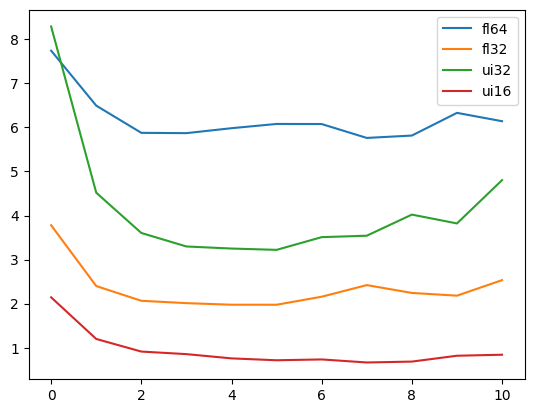

In [6]:
#Benchmark

startTime = time.time()

particle_count = exParticle_count * sample_count

poss = GenParticlePositions(exD, particle_count, steps, True)
sample_sizes = np.full((sample_count), exParticle_count, dtype=np.int32)

print("Particle generation done in " + str(time.time() - startTime) + " s")


#Convolution

def test_convolution_parallel_omp(thread_count, particle_positions, step_count, particle_count, datatyp):    
    intensities = np.full((particle_count), 1, dtype=datatyp)

    startTime = time.time()
    
    psf = PSF_subpx    
    if datatyp == np.float64:
        psf = PSF_subpx_fl64
    if datatyp == np.float32:
        psf = PSF_subpx_fl32
    if datatyp == np.uint32:
        psf = PSF_subpx_ui32
    if datatyp == np.uint16:
        psf = PSF_subpx_ui16        

    samples = SpConv.convolve(thread_count, camera_fov_px, poss, sample_sizes, intensities, psf, datatyp)
    
    perf = time.time() - startTime
    return [samples, perf]


#Testing

datatypes = [np.float64, np.float32, np.uint32, np.uint16]
str_types = ["fl64", "fl32", "ui32", "ui16"]
perfs_omp = np.zeros((len(datatypes), threads_end - threads_begin))

sampless = list()

for d in range(len(datatypes)):
    print("Datatype: " + str_types[d])
    for i in range(threads_begin, threads_end):
        samples, perfs_omp[d, i-threads_begin] = test_convolution_parallel_omp(i, poss, steps, particle_count, datatypes[d])
        print("\t Threads: " + str(i) + "--- Convolutions done in " + str(perfs_omp[d, i-threads_begin]) + " s")
    sampless.append(samples)

    plt.plot(perfs_omp[d])
plt.legend(str_types)

plt.show()

In [5]:
#Draw Fast
sample_inds = np.insert(np.cumsum(sample_sizes), 0, 0)

def plot_step_fast(step, sample_cur):
    
    begin = sample_inds[sample_cur]
    end = begin + sample_sizes[sample_cur]
    
    x = poss[step, begin:end, 1]
    y = poss[step, begin:end, 0]
    
    plt.subplot(1, 2, 1)
    plt.axis([-FOV_edge, sample_size_px-FOV_edge, -FOV_edge, sample_size_px-FOV_edge])
    plt.gca().add_patch(Rectangle((0, 0), camera_fov_px, camera_fov_px, edgecolor = 'red', fill=False))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x,y)
    
    imgs = sampless[1][sample_cur]
    plt.subplot(1, 2, 2)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])
    plt.scatter(x,y, c="red")
    plt.title(str_types[1])
    plt.show()
    


    
interact(plot_step_fast, step=IntSlider(min=0, max=steps - 1, layout=Layout(width='100%')), sample_cur=IntSlider(min=0, max=sample_count - 1, layout=Layout(width='100%')));

interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='100%'), max=63), IntSlider(v…

In [30]:

#Draw Fast & Generate targets
sample_inds = np.insert(np.cumsum(sample_sizes), 0, 0)

xc_in_sight = (poss[:, :, 0] > 0) & (poss[:, :, 0] < camera_fov_px)
yc_in_sight = (poss[:, :, 1] > 0) & (poss[:, :, 1] < camera_fov_px)
pt_in_sight = xc_in_sight & yc_in_sight

particles_in_sight_cnt = list()
for i in range(sample_count):
    particles_in_sight_cnt.append(np.sum(pt_in_sight[:, sample_inds[i]:sample_inds[i+1]], axis = 1))

precision_multiplier = 4
targets = np.zeros((steps, sample_count, camera_fov_px * precision_multiplier, camera_fov_px * precision_multiplier), dtype=np.uint8)

for i in range(sample_count):
    for step in range(steps):
        sample_pt = np.nonzero(pt_in_sight[step, sample_inds[i]:sample_inds[i+1]])
        sample_ps = poss[step, sample_inds[i]:sample_inds[i+1], :]
        positions_in_sight = (sample_ps[sample_pt, :] * precision_multiplier).astype(int)[0]
        targets[step, i, positions_in_sight[:, 0], positions_in_sight[:, 1]] = 1
    
    


def plot_step_fast_wTargets(step, sample_cur):
    
    begin = sample_inds[sample_cur]
    end = begin + sample_sizes[sample_cur]
    
    x = poss[step, begin:end, 1]
    y = poss[step, begin:end, 0]
    
    plt.subplot(1, 2, 1)
    plt.axis([-FOV_edge, sample_size_px-FOV_edge, -FOV_edge, sample_size_px-FOV_edge])
    plt.gca().add_patch(Rectangle((0, 0), camera_fov_px, camera_fov_px, edgecolor = 'red', fill=False))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x,y)
    
    imgs = sampless[1][sample_cur]
    plt.subplot(1, 2, 2)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])
    plt.scatter(x,y, c="red")
    plt.title(str_types[1])
    plt.show()
    
    plt.imshow(targets[step, sample_cur, :, :])
    plt.axis([-0.5, camera_fov_px * precision_multiplier-0.5, -0.5, camera_fov_px * precision_multiplier-0.5])
    plt.show()
    print(particles_in_sight_cnt[sample_cur][step])
    


    
interact(plot_step_fast_wTargets, step=IntSlider(min=0, max=steps - 1, layout=Layout(width='100%')), sample_cur=IntSlider(min=0, max=sample_count - 1, layout=Layout(width='100%')));


interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='100%'), max=63), IntSlider(v…

In [31]:

#Draw All
sample_inds = np.insert(np.cumsum(sample_sizes), 0, 0)

def plot_step(step, sample_cur):
    
    begin = sample_inds[sample_cur]
    end = begin + sample_sizes[sample_cur]
    
    x = poss[step, begin:end, 1]
    y = poss[step, begin:end, 0]
    
    plt.figure()
    plt.axis([-FOV_edge, sample_size_px-FOV_edge, -FOV_edge, sample_size_px-FOV_edge])
    plt.gca().add_patch(Rectangle((0, 0), camera_fov_px, camera_fov_px, edgecolor = 'red', fill=False))
    plt.scatter(x,y)
    plt.show()
    
    for d in range(len(str_types)):
        imgs = sampless[d][sample_cur]
        plt.subplot(1, 2, d%2 + 1)
        plt.imshow(imgs[step, :, :])
        plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])
        plt.scatter(x,y, c="red")
        plt.title(str_types[d])
        
        if (d + 1) % 2 == 0:
            plt.show()
    


    
interact(plot_step, step=IntSlider(min=0, max=steps - 1, layout=Layout(width='100%')), sample_cur=IntSlider(min=0, max=sample_count - 1, layout=Layout(width='100%')));


interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='100%'), max=63), IntSlider(v…